<center><img src="images/clothing.jpg"></center>

Welcome to the world of e-commerce, where customer feedback is a goldmine of insights! In this project, you'll dive into the Women's Clothing E-Commerce Reviews dataset, focusing on the 'Review Text' column filled with direct customer opinions.

Your mission is to use text embeddings and Python to analyze these reviews, uncover underlying themes, and understand customer sentiments. This analysis will help improve customer service and product offerings.

## The Data

You will be working with a dataset specifically focusing on customer reviews. Below is the data dictionary for the relevant field:

## womens_clothing_e-commerce_reviews.csv

| Column        | Description                           |
|---------------|---------------------------------------|
| `'Review Text'` | Textual feedback provided by customers about their shopping experience and product quality. |

Armed with access to powerful embedding API services, you will process the reviews, extract meaningful insights, and present your findings.

Let's get started!

## Install useful libraries

In [24]:
# Run this cell to install ChromaDB if desired
try:
    assert version('chromadb') == '0.4.17'
except:
    !pip install chromadb==0.4.17
try:
    assert version('pysqlite3') == '0.5.2'
except:
    !pip install pysqlite3-binary==0.5.2
__import__('pysqlite3')
import sys
sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')
import chromadb

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


## Load the dataset
Load data and perform basic data checks to ensure you are using relevant data for the analysis

In [25]:
# Load the dataset
import pandas as pd
reviews = pd.read_csv("womens_clothing_e-commerce_reviews.csv")

# Display the first few entries
reviews.head()

,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


## Create and Store the Embeddings
First, we'll clean the dataset by removing any reviews that are empty. Then, we'll use OpenAI's `text-embedding-3-small` model, which offers a great balance of performance and cost, to convert each review text into a numerical vector (an embedding). These embeddings capture the semantic meaning of the reviews.

In [26]:
# Start coding here
# Use as many cells as you need.
import pandas as pd
import numpy as np
from openai import OpenAI
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# --- Data Cleaning ---
# Drop rows with missing reviews and reset the index for consistency
reviews.dropna(subset=['Review Text'], inplace=True)
reviews.reset_index(drop=True, inplace=True)

# --- Embedding Generation ---
# Initialize the OpenAI client (assumes API key is set as an environment variable)
client = OpenAI()
embedding_model = "text-embedding-3-small"

# Get the list of review texts to be embedded
review_texts = reviews['Review Text'].tolist()

# Call the OpenAI API to get the embeddings
# This is done in a single batch call for efficiency
response = client.embeddings.create(input=review_texts, model=embedding_model)

# Extract the embedding vectors from the API response
embeddings = [item.embedding for item in response.data]

print(f"Successfully created {len(embeddings)} embeddings.")
print(f"Dimension of each embedding: {len(embeddings[0])}")

Successfully created 958 embeddings.
Dimension of each embedding: 1536


## Dimensionality Reduction & Visualization
The embeddings we created are high-dimensional (1536 dimensions for `text-embedding-3-small`). To visualize them, we need to reduce their dimensionality to 2D. We'll use the **t-SNE** (t-Distributed Stochastic Neighbor Embedding) algorithm, which is excellent for visualizing clusters in high-dimensional data.

The resulting plot below shows how t-SNE groups semantically similar reviews closer together. You can see several distinct clusters, which likely represent common topics or sentiments in the reviews.

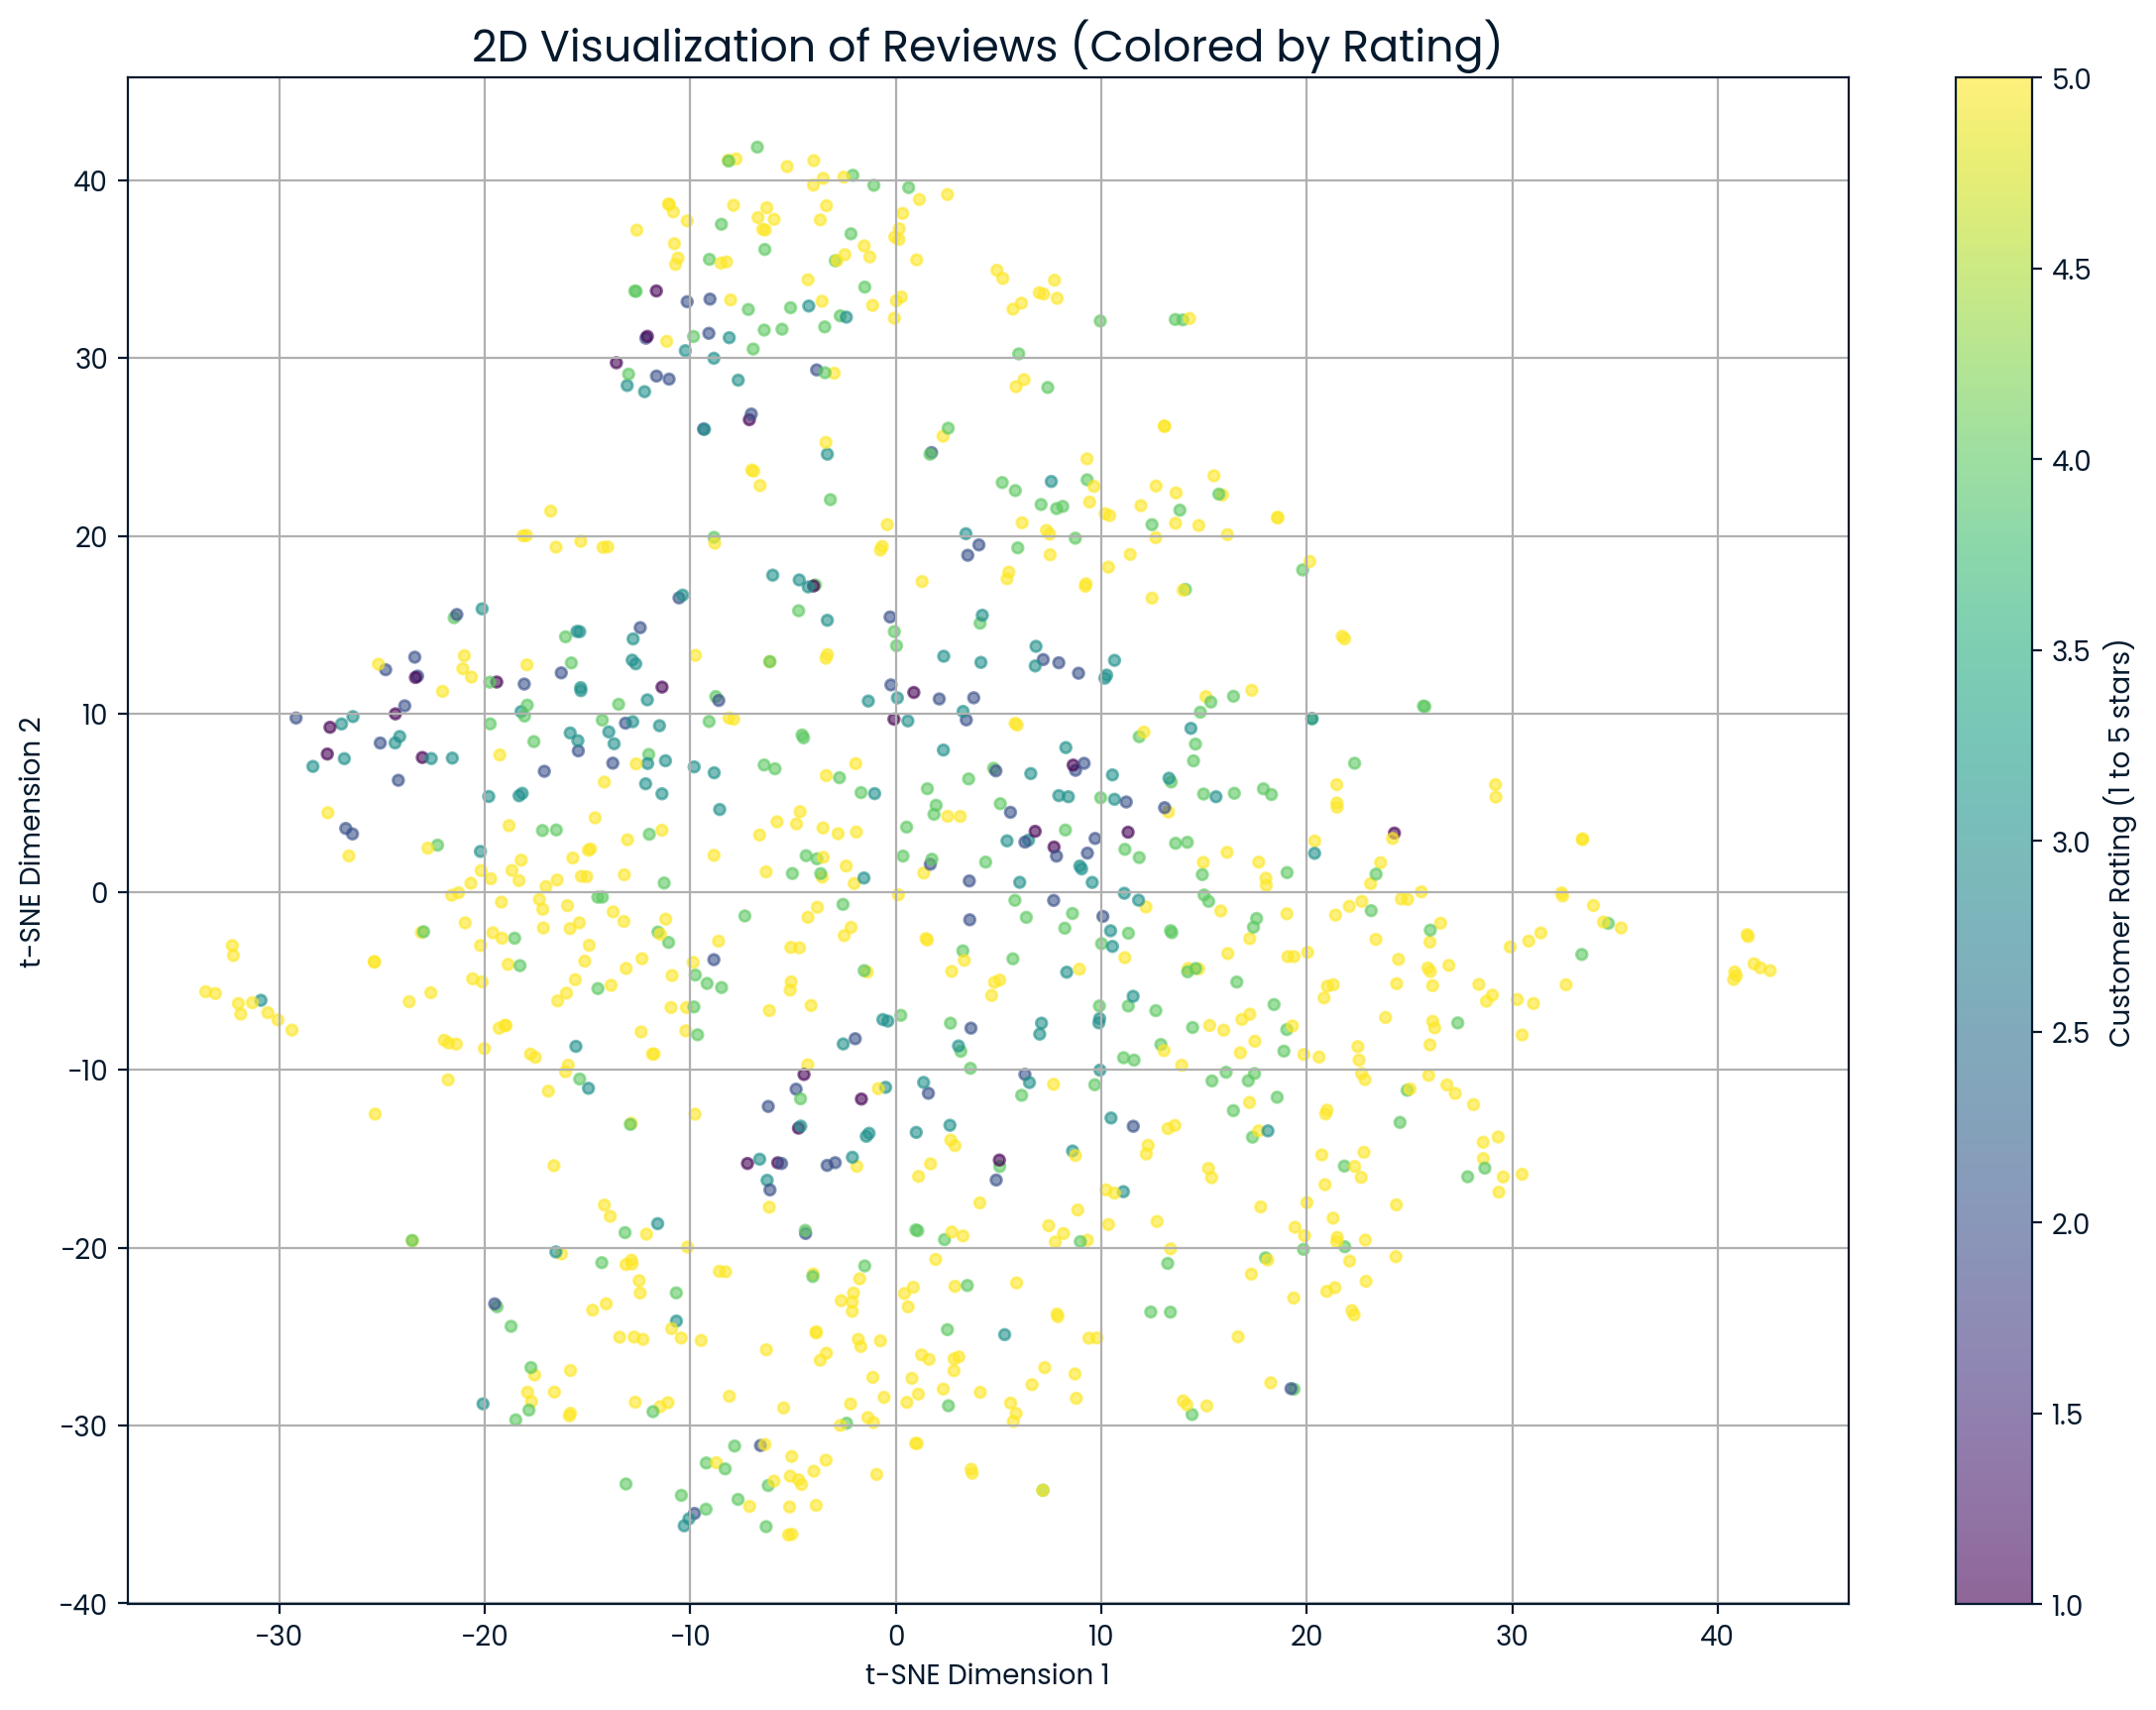

In [27]:
# The embeddings_2d array is the same as before

# --- Plotting the 2D Embeddings with Color ---
plt.figure(figsize=(14, 10))

# Use the 'Rating' column to color the points.
# 'cmap' specifies the color map to use (e.g., 'viridis', 'plasma', 'coolwarm').
scatter = plt.scatter(
    embeddings_2d[:, 0], 
    embeddings_2d[:, 1], 
    c=reviews['Rating'], # Color by the 'Rating' column
    cmap='viridis',      # Use the 'viridis' color map
    alpha=0.6, 
    s=15
)

plt.title('2D Visualization of Reviews (Colored by Rating)', fontsize=16)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# Add a color bar to show what the colors mean
colorbar = plt.colorbar(scatter)
colorbar.set_label('Customer Rating (1 to 5 stars)')

plt.grid(True)
plt.show()

## Feedback Categorization
The clusters in the t-SNE plot hint at underlying themes. We can programmatically identify reviews related to specific topics like 'quality' or 'fit' by embedding these topic words and finding the reviews whose embeddings are most similar to them.

In [28]:
def get_embedding(text, model="text-embedding-3-small"):
   """Helper function to get the embedding for a single text."""
   return client.embeddings.create(input=[text], model=model).data[0].embedding

def find_reviews_by_topic(topic, embeddings_array, reviews_df, top_n=3):
    """Finds and prints reviews most similar to a given topic."""
    topic_embedding = get_embedding(topic)
    
    # Calculate cosine similarity between the topic and all reviews
    similarities = cosine_similarity([topic_embedding], embeddings_array)[0]
    
    # Get the indices of the top N most similar reviews
    top_indices = np.argsort(similarities)[-top_n:][::-1]
    
    print(f"--- Top {top_n} reviews discussing '{topic.upper()}' ---")
    for index in top_indices:
        print(f"- {reviews_df.iloc[index]['Review Text']}\n")

# Identify reviews for different topics
find_reviews_by_topic('fabric quality', embeddings_array, reviews)
find_reviews_by_topic('fit and sizing', embeddings_array, reviews)
find_reviews_by_topic('style and design', embeddings_array, reviews)

--- Top 3 reviews discussing 'FABRIC QUALITY' ---
- Bought this item on sale and was very disappointed in the quality for the cost. fabric feels cheap, like it will snag easily and will stretch out quickly. did not flatter the female form- felt like a burlap sack. gorgeous blue color but not worth the price tag. returned it.

- The dress arrived with a few snags and the fabric already pilling. the fabric will only get worse with wear. return. cute concept; poor fabric quality.

- Very cheap looking material. looks cheap to cost $158.

--- Top 3 reviews discussing 'FIT AND SIZING' ---
- I tried this on from the sale section, and they only had a 2 (i usually do 0), and surprisingly, that size was the right fit. it is fitted, with just enough room to eat :-) 
te blue is a light blue, almost neutral, with the white embroidery, i think it looked stylish, and decided to keep it. the peplum part hit just in the right spot, i am short (petite) but my torso is normal size...

- Beautiful color,

## Similarity Search Function
Finally, we'll create a powerful function that takes any customer review as input and finds the most similar reviews in the dataset. This is incredibly useful for customer service agents to quickly find solutions to similar problems that other customers have faced.

We apply this function to the review `"Absolutely wonderful - silky and sexy and comfortable"` to demonstrate its effectiveness.

In [29]:
def find_most_similar_reviews(input_review, embeddings_array, reviews_df, top_n=3):
    """
    Finds the top N most similar reviews to a given input review.
    """
    # 1. Embed the input review
    input_embedding = get_embedding(input_review)
    
    # 2. Calculate cosine similarity with all other reviews
    similarities = cosine_similarity([input_embedding], embeddings_array)[0]
    
    # 3. Get the indices of the top N most similar reviews
    # We use argsort and select the top N from the end
    most_similar_indices = np.argsort(similarities)[-top_n:][::-1]
    
    # 4. Retrieve the review texts using the indices
    similar_reviews = reviews_df.iloc[most_similar_indices]['Review Text'].tolist()
    
    return similar_reviews

# The target review for our similarity search
input_review = "Absolutely wonderful - silky and sexy and comfortable"

# Find the 3 most similar reviews
most_similar_reviews = find_most_similar_reviews(input_review, embeddings_array, reviews)

# --- Display the results ---
print("--- Similarity Search Results ---")
print(f"Input Review: '{input_review}'\n")
print("Most Similar Reviews Found:")
for i, review in enumerate(most_similar_reviews):
    print(f"{i+1}. {review}")

--- Similarity Search Results ---
Input Review: 'Absolutely wonderful - silky and sexy and comfortable'

Most Similar Reviews Found:
1. Absolutely wonderful - silky and sexy and comfortable
2. Very comfortable and versatile. got lots of compliments.
3. This is a very comfortable and sexy sleep dress, the way it drapes. i can see that the type of fabric is not suitable for out and about activities and can catch on snags, etc. very easily. once i relegated it to the nightgown category it became my favorite item to wear and lounge in.
